In [78]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [79]:
data = pd.read_csv("../data/bitcoin_price.csv")

In [80]:
data.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
0,BTC,2020-01-01,7179.957819,7251.277888,7298.892042,7119.626946
1,BTC,2020-01-02,7174.744012,7179.957689,7237.014866,7152.992402
2,BTC,2020-01-03,6955.487580,7174.712357,7190.188749,6914.857474
3,BTC,2020-01-04,7291.219505,6955.487580,7390.041835,6852.093401
4,BTC,2020-01-05,7337.636670,7291.217504,7390.762935,7263.178696


In [81]:
data["Date"] = pd.to_datetime(data["Date"])

In [88]:
train = data[data["Date"] < "2021-01-01"]
test = data[data["Date"] >= "2021-01-01"]

## Grid Search

In [83]:
ts = train["Closing Price (USD)"]

In [84]:
def simple_moving_average(window_size):
    predicted = [np.nan,] + ts.rolling(window_size).mean().tolist()[:-1]
    actual = [np.nan] * window_size + ts.copy()[window_size:].tolist()
    rmse = mean_squared_error(actual[window_size:], predicted[window_size:], squared = False)
    return rmse

In [85]:
# window_size grid search
sizes = range(1,21)
errors = []
for size in sizes:
    errors.append(simple_moving_average(size))

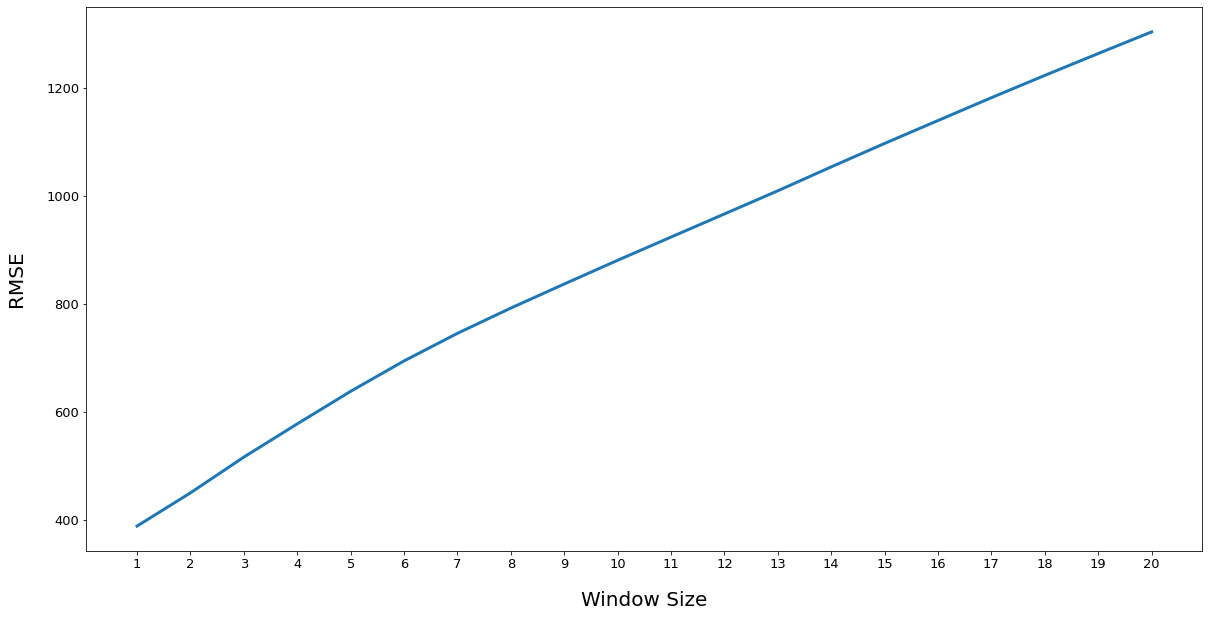

In [86]:
plt.figure(figsize=(20,10)) 
plt.plot(sizes, errors, lw = 3)
plt.xticks(sizes, size = 13)
plt.yticks(size = 13)
plt.ylabel("RMSE", size = 20, labelpad = 20)
plt.xlabel("Window Size", size = 20, labelpad = 20)
plt.show()

## Prediction

In [89]:
test["regression"] = [np.nan,] + test["Closing Price (USD)"].rolling(2).mean().tolist()[:-1]

In [91]:
test["close_lag"] = test["Closing Price (USD)"].shift(periods = 1)
test["classification"] = test["regression"] - test["close_lag"]
test["classification"] = test["classification"].apply(lambda x : 1 if x > 0 else -1)

In [92]:
test.head()

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),regression,close_lag,classification
366,BTC,2021-01-01,29111.521567,28872.829775,29280.045328,27916.625059,NaN,NaN,-1
367,BTC,2021-01-02,29333.605121,28935.810981,29601.594898,28753.412314,NaN,29111.521567,-1
368,BTC,2021-01-03,32154.167363,29353.640608,33064.673534,29012.927887,29222.563344,29333.605121,-1
369,BTC,2021-01-04,33002.536427,32074.106611,34452.080337,31885.581619,30743.886242,32154.167363,-1
370,BTC,2021-01-05,31431.612280,32788.583453,33358.399346,28154.110298,32578.351895,33002.536427,-1


In [95]:
test = test.dropna()
regression_pred = test.regression.tolist()
classification_pred = test.classification.tolist()
date = test.Date.tolist()

In [110]:
from datetime import datetime, timedelta
import logging 

In [115]:
def backtest_classification_noSentiment(y_pre, date): # up --> 1, down --> -1
    logging.basicConfig(filename='example.log', filemode='w') 
    
    # read in data
    data = pd.read_csv("../data/bitcoin_price.csv")
    # convert to datetime
    data["Date"] = pd.to_datetime(data["Date"])
    # subset data set
    data = data[data["Date"].isin(date)]

    open_p, close_p = data["24h Open (USD)"].tolist(), data["Closing Price (USD)"].tolist()  
    
    # init portfolio at 1
    portfolio = [1,]
    # loop every day
    for i in range(len(date)):
        logging.info("---------------------------------------------")
        logging.info(date[i])
        pre = y_pre[i]
        open_price = open_p[i]
        close_price = close_p[i]
        # if predicted up
        if pre == 1: # strategy --> buy at open, sell at close
            print("Predicted price UP, LONG {} at open".format("100%"))
            print("Predicted price UP, SELL {} at close".format("100%"))
            percentage = (close_price - open_price) / open_price
            new_portfolio = portfolio[-1] * (1 + percentage)
            portfolio.append(new_portfolio)
            print("Percentage return is {} and the new portfolio is {}".format(
                round(percentage,2), round(new_portfolio,2)))

        # if predicted down
        else: # strategy --> short at open, cover at close
            print("Predicted price DOWN, SHORT {} at open".format("100%"))
            print("Predicted price DOWN, COVER {} at close".format("100%"))
            percentage = (open_price - close_price) / open_price
            new_portfolio = portfolio[-1] * (1 + percentage)
            portfolio.append(new_portfolio)
            print("Percentage return is {} and the new portfolio is {}".format(
                round(percentage,2), round(new_portfolio,2)))
    return portfolio

In [116]:
backtest_classification_noSentiment(classification_pred, date)

Predicted price DOWN, SHORT 100% at open
Predicted price DOWN, COVER 100% at close
Percentage return is -0.1 and the new portfolio is 0.9
Predicted price DOWN, SHORT 100% at open
Predicted price DOWN, COVER 100% at close
Percentage return is -0.03 and the new portfolio is 0.88
Predicted price DOWN, SHORT 100% at open
Predicted price DOWN, COVER 100% at close
Percentage return is 0.04 and the new portfolio is 0.91
Predicted price UP, LONG 100% at open
Predicted price UP, SELL 100% at close
Percentage return is 0.08 and the new portfolio is 0.98
Predicted price DOWN, SHORT 100% at open
Predicted price DOWN, COVER 100% at close
Percentage return is -0.07 and the new portfolio is 0.92
Predicted price DOWN, SHORT 100% at open
Predicted price DOWN, COVER 100% at close
Percentage return is -0.08 and the new portfolio is 0.85
Predicted price DOWN, SHORT 100% at open
Predicted price DOWN, COVER 100% at close
Percentage return is -0.03 and the new portfolio is 0.82
Predicted price DOWN, SHORT 10

[1,
 0.9045935462423291,
 0.8784088225324191,
 0.9147621908315032,
 0.9845784364864142,
 0.9187182001908584,
 0.8461549146004156,
 0.8225727877831903,
 0.8286405221981656,
 0.7999853760450744,
 0.721882511144505,
 0.6970628216246918,
 0.757350545592663,
 0.7358153700957323,
 0.7804989858551348,
 0.7648691255136779,
 0.772494260398699,
 0.7617460053345644,
 0.7604473304734557,
 0.7796102204851026,
 0.6723002401085197,
 0.727303672476712,
 0.747807831430012,
 0.7519613857972474,
 0.7472408501075273,
 0.7459967147859636,
 0.700938994332495,
 0.7696397162222064,
 0.7369895165834999,
 0.7293111322198723,
 0.7034404796796742,
 0.7135136832337593,
 0.6686576567449994,
 0.6333096487137745,
 0.6398653791632039,
 0.6551093881334163,
 0.620947070381637,
 0.6334685470365299,
 0.7290658495084021,
 0.7252761530879097,
 0.7451652315883117,
 0.7890356107080388,
 0.7908184484297344,
 0.7974973535437913,
 0.8299171180958932,
 0.8389376436181012,
 0.8546147123696474,
 0.8028550005031363,
 0.8092828683431

In [100]:
def backtest_regression_noSentiment(y_pre, date):
    # read in data
    data = pd.read_csv("../data/bitcoin_price.csv")
    # convert to datetime
    data["Date"] = pd.to_datetime(data["Date"])
    # subset data set
    data = data[data["Date"].isin(
        [date[0]- timedelta(days=1),] + date) # add in the previous day to obtain previous close information
                   ]
    # append predicted value
    data["predicted"] = [np.nan, ] + y_pre
    
    
    extended_date, predicted = data["Date"].tolist(), data["predicted"].tolist()
    open_p, close_p = data["24h Open (USD)"].tolist(), data["Closing Price (USD)"].tolist()
    high, low = data["24h High (USD)"].tolist(), data["24h Low (USD)"].tolist()
    
    # init portfolio at 1
    portfolio = [1,]
    # loop every day
    for i in range(len(extended_date)):
        if i == 0: # day 0 is added to obtain day 0 close price
            continue
        print("---------------------------------------------")
        print(extended_date[i])
        pre = predicted[i]
        open_price = open_p[i]
        close_price = close_p[i]
        high_price = high[i]
        low_price = low[i]
        # if the predicted price higher than the previous close --> long position
        if pre > close_p[i-1]:
            print("Predicted price {} is higher than the previous close {}, LONG {}".format(
                round(pre,2), round(close_p[i-1],2), "100%"))
            # strategy --> buy at open, sell on hit or at close
            if pre <= high_price: # on hit
                print("Price movement hit the predicted price, SELL 100% on hit {}".format(round(pre,2)))

                percentage = (pre - open_price) / open_price
                new_portfolio = portfolio[-1] * (1 + percentage)
                portfolio.append(new_portfolio)

                print("Percentage return is {} and the new portfolio is {}".format(
                    round(percentage,2), round(new_portfolio,2)))
            else: # at close
                print("Price movement does not hit the predicted price, SELL 100% at close {}".format(
                    round(close_price,2)))

                percentage = (close_price - open_price) / open_price
                new_portfolio = portfolio[-1] * (1 + percentage)
                portfolio.append(new_portfolio)
                print("Percentage return is {} and the new portfolio is {}".format(
                    round(percentage,2), round(new_portfolio,2)))

        # if the predicted price lower than the previous close --> short position
        elif pre < close_p[i-1]:
            print("Predicted price {} is lower than the previous close {}, SHORT {}".format(
                round(pre,2), close_p[i-1], "100%"))
            # strategy --> short at open, cover on hit or at close
            if pre >= low_price: # on hit
                print("Price movement hit the predicted price, COVER 100% on hit {}".format(round(pre,2)))

                percentage = (open_price - pre) / open_price
                new_portfolio = portfolio[-1] * (1 + percentage)
                portfolio.append(new_portfolio)

                print("Percentage return is {} and the new portfolio is {}".format(
                    round(percentage,2), round(new_portfolio,2)))
            else: # at close
                print("Price movement does not hit the predicted price, SELL 100% at close {}".format(
                    round(close_price,2)))

                percentage = (open_price - close_price) / open_price
                new_portfolio = portfolio[-1] * (1 + percentage)
                portfolio.append(new_portfolio)

                print("Percentage return is {} and the new portfolio is {}".format(
                    round(percentage,2), round(new_portfolio,2)))
        else:
            print("Predicted price {} is same as the previous close {}, NO ACTION".format(
                round(pre,2), round(close_p[i-1],2)))
    return portfolio

In [101]:
backtest_regression_noSentiment(regression_pred, date)

---------------------------------------------
2021-01-03 00:00:00
Predicted price 29222.56 is lower than the previous close 29333.6051206224, SHORT 100%
Price movement hit the predicted price, COVER 100% on hit 29222.56
Percentage return is 0.0 and the new portfolio is 1.0
---------------------------------------------
2021-01-04 00:00:00
Predicted price 30743.89 is lower than the previous close 32154.1673632745, SHORT 100%
Price movement does not hit the predicted price, SELL 100% at close 33002.54
Percentage return is -0.03 and the new portfolio is 0.98
---------------------------------------------
2021-01-05 00:00:00
Predicted price 32578.35 is lower than the previous close 33002.5364270397, SHORT 100%
Price movement hit the predicted price, COVER 100% on hit 32578.35
Percentage return is 0.01 and the new portfolio is 0.98
---------------------------------------------
2021-01-06 00:00:00
Predicted price 32217.07 is higher than the previous close 31431.61, LONG 100%
Price movement hit

[1,
 1.0044654516918856,
 0.9753897961801271,
 0.9816437325952913,
 0.988552182402419,
 0.9224261350396002,
 0.8495699849610868,
 0.8803057896491063,
 0.8898911511943352,
 0.8963906825431512,
 0.8088757323037955,
 0.8345998025103253,
 0.8405230453864377,
 0.8166228694415628,
 0.8458678216621082,
 0.8652224202312574,
 0.8740490899075463,
 0.8655528176295175,
 0.8589672557362852,
 0.8457480806104894,
 0.7293345093807899,
 0.7756916469641993,
 0.7995067586118588,
 0.8147421943356188,
 0.8177590517506402,
 0.8146633179891021,
 0.8125214224611095,
 0.8393248107554762,
 0.803718380817843,
 0.8070019158784802,
 0.7783753596082926,
 0.795195254464644,
 0.74520420280556,
 0.7058096278987191,
 0.7270102231744194,
 0.7340112932146787,
 0.6957344382551715,
 0.6988544317306431,
 0.708368497926022,
 0.7046863866835464,
 0.7170675559033631,
 0.734591749302462,
 0.7362515703079138,
 0.7317944617698343,
 0.7351032370622914,
 0.7438155983062923,
 0.7545838571621922,
 0.7088825107419562,
 0.7145580101662

In [179]:
portfolio = [1,]
for i in range(len(date)):
    if i == 0:
        continue
    print("---------------")
    print(date[i])
    pre = predicted[i]
    open_price = open_p[i]
    close_price = close_p[i]
    high_price = high[i]
    low_price = low[i]
    # if the predicted price higher than the previous close --> long position
    if pre > close_p[i-1]:
        print("Predicted price {} is higher than the previous close {}, LONG {}".format(
            round(pre,2), round(close_p[i-1],2), "100%"))
        # strategy --> buy at open, sell on hit or at close
        if pre <= high_price: # on hit
            print("Price movement hit the predicted price, SELL 100% on hit {}".format(round(pre,2)))
            
            percentage = (pre - open_price) / open_price
            new_portfolio = portfolio[-1] * (1 + percentage)
            portfolio.append(new_portfolio)
            
            print("Percentage return is {} and the new portfolio is {}".format(
                round(percentage,2), round(new_portfolio,2)))
        else: # at close
            print("Price movement does not hit the predicted price, SELL 100% at close {}".format(
                round(close_price,2)))
            
            percentage = (close_price - open_price) / open_price
            new_portfolio = portfolio[-1] * (1 + percentage)
            portfolio.append(new_portfolio)
            print("Percentage return is {} and the new portfolio is {}".format(
                round(percentage,2), round(new_portfolio,2)))
   
    # if the predicted price higher than the previous close --> long position
    elif pre < close_p[i-1]:
        print("Predicted price {} is lower than the previous close {}, SHORT {}".format(
            round(pre,2), close_p[i-1], "100%"))
        # strategy --> short at open, cover on hit or at close
        if pre >= low_price: # on hit
            print("Price movement hit the predicted price, COVER 100% on hit {}".format(round(pre,2)))
            
            percentage = (open_price - pre) / open_price
            new_portfolio = portfolio[-1] * (1 + percentage)
            portfolio.append(new_portfolio)
            
            print("Percentage return is {} and the new portfolio is {}".format(
                round(percentage,2), round(new_portfolio,2)))
        else: # at close
            print("Price movement does not hit the predicted price, SELL 100% at close {}".format(
                round(close_price,2)))
            
            percentage = (open_price - close_price) / open_price
            new_portfolio = portfolio[-1] * (1 + percentage)
            portfolio.append(new_portfolio)
            
            print("Percentage return is {} and the new portfolio is {}".format(
                round(percentage,2), round(new_portfolio,2)))
    else:
        print("Predicted price {} is same as the previous close {}, NO ACTION".format(
            round(pre,2), round(close_p[i-1],2)))

---------------
2021-01-02 00:00:00
Predicted price nan is same as the previous close 29111.52, NO ACTION
---------------
2021-01-03 00:00:00
Predicted price 29222.56 is lower than the previous close 29333.6051206224, SHORT 100%
Price movement hit the predicted price, COVER 100% on hit 29222.56
Percentage return is 0.0 and the new portfolio is 1.0
---------------
2021-01-04 00:00:00
Predicted price 30743.89 is lower than the previous close 32154.1673632745, SHORT 100%
Price movement does not hit the predicted price, SELL 100% at close 33002.54
Percentage return is -0.03 and the new portfolio is 0.98
---------------
2021-01-05 00:00:00
Predicted price 32578.35 is lower than the previous close 33002.5364270397, SHORT 100%
Price movement hit the predicted price, COVER 100% on hit 32578.35
Percentage return is 0.01 and the new portfolio is 0.98
---------------
2021-01-06 00:00:00
Predicted price 32217.07 is higher than the previous close 31431.61, LONG 100%
Price movement hit the predicted

In [142]:
true_y

,Currency,Date,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD),predicted
367,BTC,2021-01-02,29333.605121,28935.810981,29601.594898,28753.412314,29111.521567
368,BTC,2021-01-03,32154.167363,29353.640608,33064.673534,29012.927887,29333.605121
369,BTC,2021-01-04,33002.536427,32074.106611,34452.080337,31885.581619,32154.167363
370,BTC,2021-01-05,31431.612280,32788.583453,33358.399346,28154.110298,33002.536427
371,BTC,2021-01-06,34433.606514,31991.926865,34435.417475,29948.653628,31431.612280
372,BTC,2021-01-07,36275.756348,34001.344764,36461.691774,33351.028120,34433.606514
373,BTC,2021-01-08,39713.507857,36806.419755,40324.014033,36356.430756,36275.756348
374,BTC,2021-01-09,40519.448598,39420.800696,41962.362125,36741.330177,39713.507857
375,BTC,2021-01-10,40258.923989,40558.102123,41375.430681,38766.276161,40519.448598
376,BTC,2021-01-11,38709.765375,40096.333202,41186.523430,34897.550466,40258.923989
